In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indian-pines/Indian_pines_corrected.mat
/kaggle/input/indian-pines/Indian_pines_gt.mat


In [2]:
# # Kaggle运行使用
def LoadData():
    data_path = '../input/'
    data = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_gt.mat'))['indian_pines_gt']  
    return data, labels

In [3]:
# # 本地运行使用
# def LoadData():
#     data_path = './data/'
#     data = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_corrected.mat'))['indian_pines_corrected']
#     labels = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_gt.mat'))['indian_pines_gt']

In [4]:
if __name__ == '__main__':
    # 读取数据
    data, labels = LoadData()
#     # 删除标签为0的数据
#     data = data[labels != 0]
#     labels = labels[labels != 0]
#     # 将标签从1开始重新编号
#     labels -= 1

    X = data.reshape(-1, 200)
    y = labels.reshape(-1, )
    standard_scaler = StandardScaler()
    X = standard_scaler.fit_transform(X)

#     进行PCA降维
    pca_dims = 150
    pca = PCA(n_components=pca_dims)
    X_pca = pca.fit_transform(X)
    print(pca.explained_variance_ratio_.sum())
    print(X_pca.shape)

0.9997740127489396
(21025, 150)


In [5]:
    # 检查GPU是否可用
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}') 

    losses = []
    accs = []
    taccs = []
    for i in range(10):
        # 划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=i+i, stratify=y)
        # 转换为PyTorch张量
        X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
        y_test = torch.tensor(y_test, dtype=torch.int64).to(device)
        
        # 定义模型
        class MLP(nn.Module):
            def __init__(self):
                super(MLP, self).__init__()
                self.fc1 = nn.Linear(X_train.shape[1], 512)
                self.fc2 = nn.Linear(512, 256)
                self.fc3 = nn.Linear(256, 128)
                self.fc4 = nn.Linear(128, np.unique(y_train.cpu().numpy()).size)
                self.dropout = nn.Dropout(p=0.2)
                self.relu = nn.LeakyReLU()

            def forward(self, x):
                x = self.relu(self.fc1(x))
                x = self.dropout(x)
                x = self.relu(self.fc2(x))
                x = self.dropout(x)
                x = self.relu(self.fc3(x))
                x = self.dropout(x)
                x = self.fc4(x)
                return x

        model = MLP().to(device)
        # 定义损失函数和优化器
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)

#         losses = []
#         accs = []
        # 训练模型
        for epoch in range(5000):
            # 前向传播
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 输出训练结果
            if ((epoch+1) % 10 == 1) & (i == 9):
                _, predicted = torch.max(outputs.data, 1)
                train_acc = torch.sum(predicted == y_train).item() / y_train.size(0)
#                 print(f"Epoch {epoch+1:3d}: Train Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}")
                losses.append(loss.item())
                accs.append(train_acc)
#                 print(len(losses))

        # 在测试集上进行评估
        with torch.no_grad():
            outputs = model(X_test)
            _, predicted = torch.max(outputs.data, 1)
            test_acc = torch.sum(predicted == y_test).item() / y_test.size(0)
            taccs.append(test_acc)
            print(f"test acc: {test_acc:.4f}")
#             print(len(losses))
    #         print(classification_report(y_test.cpu().numpy(), predicted.cpu().numpy()))
    print("Test Acc: %.2f%% (+/- %.2f%%)" % (np.mean(taccs)*100, np.std(taccs)*100))

Device: cuda
test acc: 0.8269
test acc: 0.8228
test acc: 0.8319
test acc: 0.8321
test acc: 0.8212
test acc: 0.8235
test acc: 0.8376
test acc: 0.8369
test acc: 0.8271
test acc: 0.8245
Test Acc: 82.84% (+/- 0.55%)


In [6]:
    # 在总数据集上进行评估
    with torch.no_grad():
        X_pca1 = torch.tensor(X_pca, dtype=torch.float32).to(device)
        y1 = torch.tensor(y, dtype=torch.int64).to(device)
        outputs_pca = model(X_pca1)
        _, predicted = torch.max(outputs_pca.data, 1)
        pca_acc = torch.sum(predicted == y1).item() / y1.size(0)
        print(f"Acc: {pca_acc:.4f}")
        print(classification_report(y1.cpu().numpy(), predicted.cpu().numpy()))
        cm = confusion_matrix(y1.cpu().numpy(), predicted.cpu().numpy())
        print(cm)

Acc: 0.9629
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10776
           1       1.00      0.96      0.98        46
           2       0.97      0.96      0.96      1428
           3       0.97      0.96      0.96       830
           4       0.95      0.95      0.95       237
           5       0.97      0.96      0.96       483
           6       0.95      0.97      0.96       730
           7       0.90      0.93      0.91        28
           8       0.98      0.98      0.98       478
           9       0.94      0.85      0.89        20
          10       0.95      0.95      0.95       972
          11       0.96      0.96      0.96      2455
          12       0.96      0.95      0.96       593
          13       0.98      0.99      0.98       205
          14       0.93      0.92      0.93      1265
          15       0.94      0.86      0.90       386
          16       0.97      0.91      0.94        93

    accuracy  

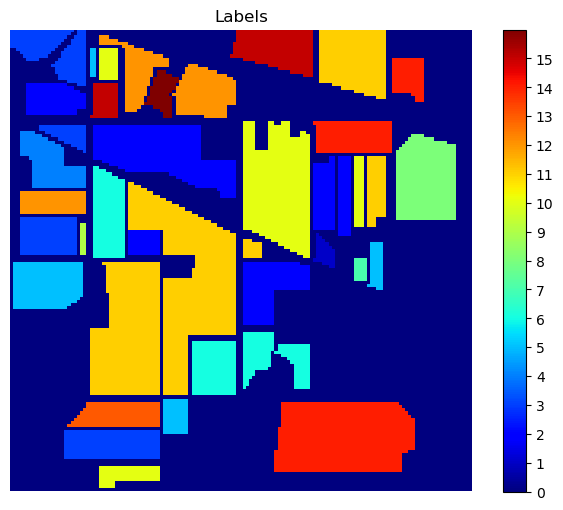

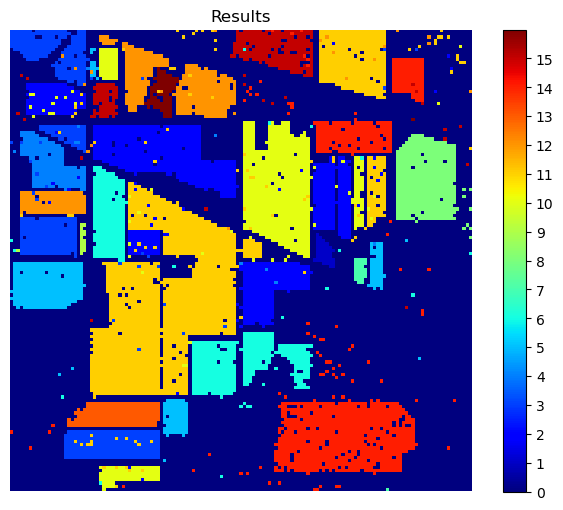

In [7]:
    # 绘制标签
    plt.figure(figsize=(8, 6))
    plt.imshow(labels, cmap='jet')
    plt.axis('off')
    plt.colorbar(ticks= range(0,16))
    plt.title("Labels")
    plt.show()
    
    # 绘制所有数据的预测结果
#     y_pred_pca = clf.predict(X_pca)
    Y_pred2 = predicted.cpu().numpy().reshape(145, 145)
    plt.figure(figsize=(8, 6))
    plt.imshow(Y_pred2, cmap='jet')
    plt.axis('off')
    plt.colorbar(ticks= range(0,16))
    plt.title("Results")
    plt.show()

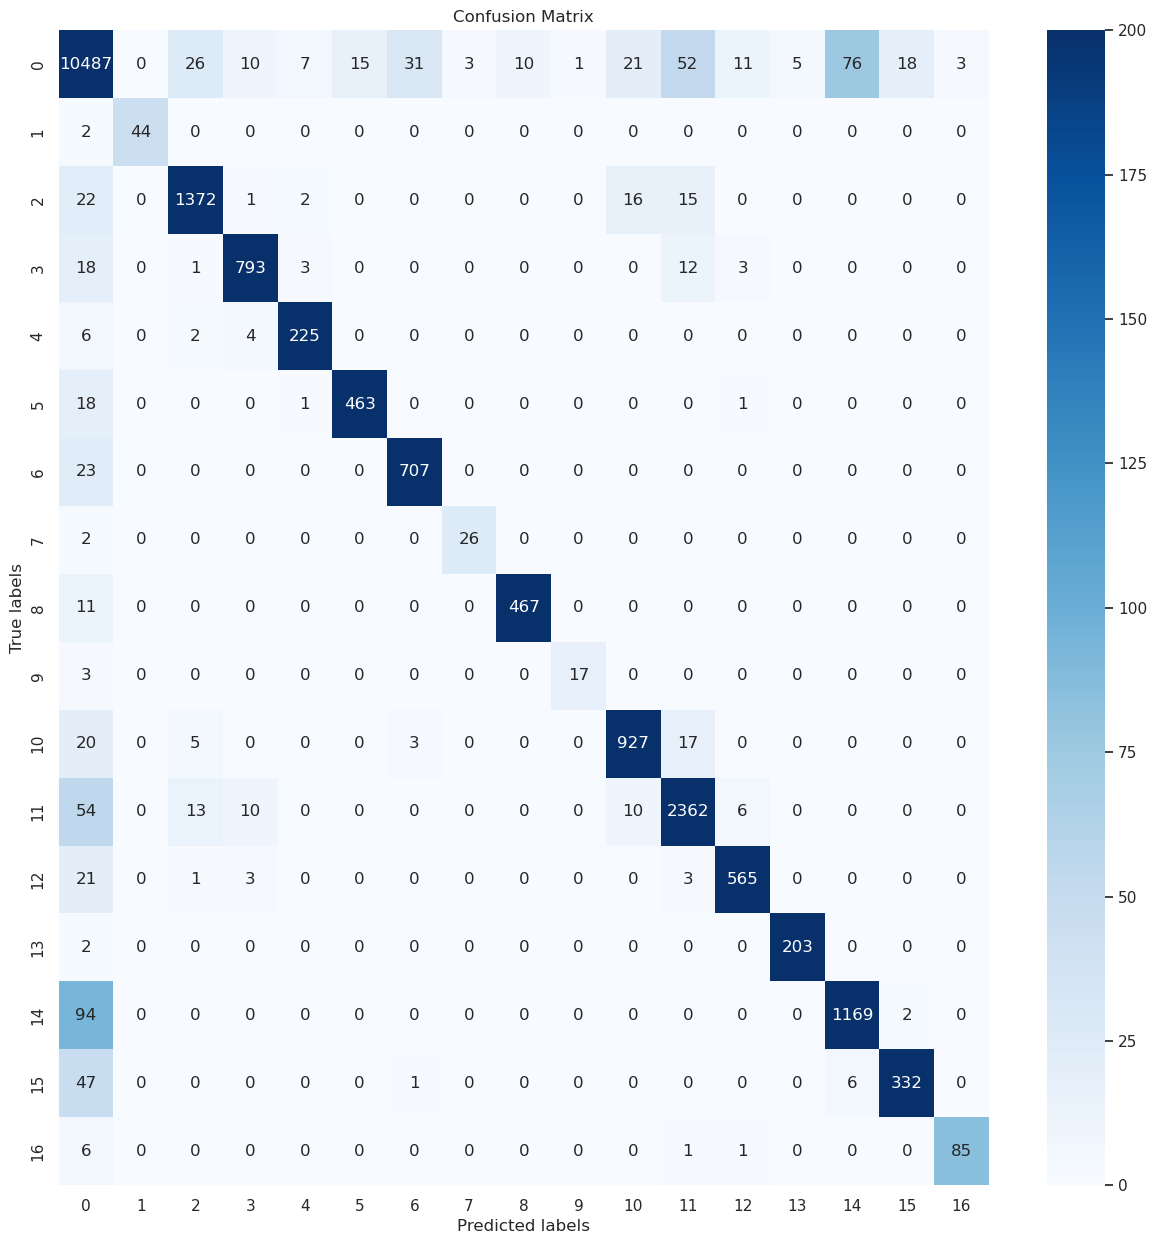

In [8]:
    # 绘制混淆矩阵图
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', vmin=0, vmax=200)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

500
500


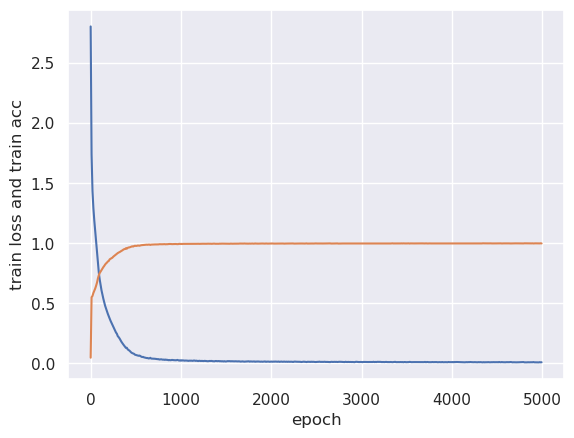

In [9]:
    # 绘制loss和acc的变化
    print(len(losses))
    print(len(accs))
    plt.plot(range(0, 5000, 10), losses)
    plt.plot(range(0, 5000, 10), accs)
    plt.xlabel("epoch")
    plt.ylabel("train loss and train acc")
    plt.show()